<a href="https://colab.research.google.com/github/myanez987/Crypto_Reinforcement_Learning-/blob/main/Crypto_Reinforcement_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install stable-baselines3 gymnasium pandas matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
from stable_baselines3 import PPO

# Assuming 'historical_data' is a pandas DataFrame with historical prices
# Create a dummy historical_data for demonstration purposes if it doesn't exist
try:
    historical_data
except NameError:
    print("Creating dummy historical_data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D'))
    crypto_names = [f'crypto_{i}' for i in range(25)]
    data = np.random.rand(100, 25) * 1000 # Simulate price data
    historical_data = pd.DataFrame(data, index=dates, columns=crypto_names)


# Instantiate the environment
env = CryptoTradingEnv(historical_data=historical_data)

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=0)

print("PPO agent created.")

PPO agent created.


In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd

class CryptoTradingEnv(gym.Env):
    """Custom Gymnasium environment for cryptocurrency trading."""

    def __init__(self, historical_data, initial_balance=100000, transaction_fee=0.001):
        super().__init__()
        self.historical_data = historical_data
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.n_cryptos = historical_data.shape[1] # Assuming each column is a crypto price series

        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_cryptos) # Number of units of each crypto held

        # Define observation space: current prices, current balance, current holdings
        # The shape should be n_cryptos (prices) + 1 (balance) + n_cryptos (holdings)
        obs_low = np.array([0.0] * (self.n_cryptos + 1 + self.n_cryptos)) # min price is 0, min balance 0, min holdings 0
        obs_high = np.array([np.inf] * (self.n_cryptos + 1 + self.n_cryptos)) # max is infinity
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)


        # Define action space: for each crypto, buy, sell, or hold (represented by a value between -1 and 1)
        # -1: sell, 0: hold, 1: buy
        # We'll use a continuous action space for simplicity, where the value represents the fraction of current balance to trade (for buy) or fraction of holdings to trade (for sell)
        self.action_space = gym.spaces.Box(low=np.array([-1.0] * self.n_cryptos), high=np.array([1.0] * self.n_cryptos), dtype=np.float32)


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_cryptos)
        observation = self._get_observation()
        info = {} # Optional: any additional info to return
        return observation, info

    def step(self, action):
        # action is an array of size n_cryptos, with values between -1 and 1
        # -1 means sell, 1 means buy, 0 means hold
        # The magnitude indicates the fraction of balance (for buy) or holdings (for sell)

        portfolio_value_before = self._get_portfolio_value()

        for i in range(self.n_cryptos):
            current_price = self._get_current_prices()[i]
            trade_action = action[i]

            if trade_action > 0: # Buy
                amount_to_spend = self.balance * trade_action
                if amount_to_spend > 0 and current_price > 0:
                    num_units_to_buy = amount_to_spend / current_price
                    transaction_cost = num_units_to_buy * current_price * self.transaction_fee
                    if self.balance >= amount_to_spend + transaction_cost:
                        self.balance -= amount_to_spend + transaction_cost
                        self.holdings[i] += num_units_to_buy

            elif trade_action < 0: # Sell
                fraction_to_sell = abs(trade_action)
                num_units_to_sell = self.holdings[i] * fraction_to_sell
                if num_units_to_sell > 0 and current_price > 0:
                    transaction_cost = num_units_to_sell * current_price * self.transaction_fee
                    self.balance += num_units_to_sell * current_price - transaction_cost
                    self.holdings[i] -= num_units_to_sell


        self.current_step += 1

        done = self.current_step >= len(self.historical_data) - 1 # Episode ends when data runs out

        portfolio_value_after = self._get_portfolio_value()
        reward = portfolio_value_after - portfolio_value_before # Reward is the change in portfolio value

        observation = self._get_observation()
        info = {'portfolio_value': portfolio_value_after}

        truncated = False # No truncation in this environment

        return observation, reward, done, truncated, info

    def _get_observation(self):
        # Returns the current observation for the agent
        # This includes the current prices, current balance, and current holdings
        current_prices = self._get_current_prices()
        observation = np.concatenate([current_prices, [self.balance], self.holdings])
        return observation


    def _get_current_prices(self):
        # Returns the current prices of all cryptocurrencies
        if self.current_step < len(self.historical_data):
            return self.historical_data.iloc[self.current_step].values
        else:
            return self.historical_data.iloc[-1].values # Return last prices if at the end


    def _get_portfolio_value(self):
        # Calculates the total value of the portfolio (balance + value of holdings)
        current_prices = self._get_current_prices()
        holdings_value = np.sum(self.holdings * current_prices)
        return self.balance + holdings_value

In [ ]:
from stable_baselines3 import PPO

# Instantiate the corrected environment
env = CryptoTradingEnv(historical_data=historical_data)

# Instantiate the agent again
model = PPO("MlpPolicy", env, verbose=0)

# Train the agent
model.learn(total_timesteps=10000)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/utils.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else float(1 - np.var(y_true - y_pred) / var_y)


Model training complete.


In [ ]:
# Create a new instance of the environment for evaluation (using the same historical data)
eval_env = CryptoTradingEnv(historical_data=historical_data)

# Reset the environment
obs, info = eval_env.reset()

# Initialize list to store portfolio values, getting the initial value from the environment
portfolio_values = [eval_env._get_portfolio_value()]

# Iterate through the environment
done = False
truncated = False
while not done and not truncated:
    # Get action from the trained model
    action, _states = model.predict(obs, deterministic=True)

    # Take a step in the environment
    obs, reward, done, truncated, info = eval_env.step(action)

    # Append portfolio value from the info dictionary returned by step
    portfolio_values.append(info['portfolio_value'])

# Store the list of portfolio values
# This is already done by appending to the portfolio_values list in the loop.

print("Evaluation complete. Portfolio values stored.")

Evaluation complete. Portfolio values stored.


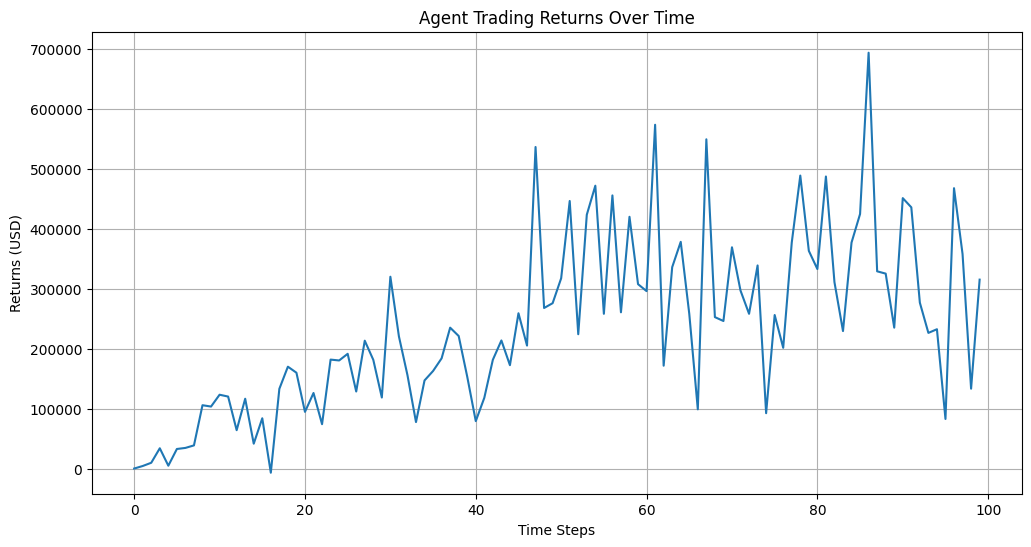

In [ ]:
import matplotlib.pyplot as plt

# Calculate the returns in dollars
initial_balance = 100000  # Assuming the initial balance was 100000 as set in the environment
returns_in_dollars = [value - initial_balance for value in portfolio_values]

plt.figure(figsize=(12, 6))
plt.plot(returns_in_dollars)
plt.xlabel('Time Steps')
plt.ylabel('Returns (USD)')
plt.title('Agent Trading Returns Over Time')
plt.grid(True)
plt.show()

This project implements a cryptocurrency trading agent using reinforcement learning. A custom trading environment, CryptoTradingEnv, was created using the Gymnasium library to simulate trading on historical price data for 25 different cryptocurrencies. The environment manages the agent's balance and holdings, incorporating transaction fees and calculating portfolio value at each step. The agent's actions are represented as a continuous space, allowing it to decide what fraction of its balance to use for buying or what fraction of its holdings to sell for each cryptocurrency. The observation space provides the agent with current prices, its current balance, and its current holdings.

The reinforcement learning agent uses the Proximal Policy Optimization (PPO) algorithm from the stable-baselines3 library. The PPO agent was trained within the custom CryptoTradingEnv using historical data. The goal of the training is to maximize the agent's cumulative reward, which is defined as the change in portfolio value at each time step. After training, the agent's performance was evaluated on the same historical data, and the returns in USD over time were visualized to show the profitability of the learned trading strategy.

